In [712]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import magpylib as magpy
from mayavi import mlab
from scipy.spatial.transform import Rotation as R
import scipy.constants as constants
from scipy import stats
import math
from math import pi, sqrt, ceil 
from math import log as ln
from scipy.optimize import curve_fit
from scipy import constants
import jdc

from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.special import kn
from tqdm import tqdm, trange

In [699]:
b_x=3e-3 # m
b_y=3e-3 # m
b_z=1e-4 # m

m=1e-5 # kg
w=1e-3 # m, width of graphite plate
chi=1e-4 # magnetic susceptibility

$\textbf{F}_\textbf{B}=\nabla\int_V\textbf{M}\cdot\textbf{B}{dV}=\frac{\mu_0}{2}\int_V\nabla(\chi_x H_x^2+\chi_y H_y^2 + \chi_z H_z^2){dV}$

$    B^{(1)}_z(x,y,z)=-\frac{B_0}{2\pi}[F_1(-x,y,z)+F_1(-x,y,-z)\\
    +F_1(-x,-y,z)+F_1(-x,-y,-z)\\
    +F_1(x,y,z)+F_1(x,y,-z)\\
    +F_1(x,-y,z)+F_1(x,-y,-z)]$
    
$F_1(x,y,z)=\\
tan^{-1}\left[\frac{(x+\frac{b_x}{2})(y+\frac{b_y}{2})}{(z+\frac{b_z}{2})\sqrt{(x+\frac{b_x}{2})^2+(y+\frac{b_y}{2})^2+(z+\frac{b_z}{2})^2}}\right]$

In [702]:
def find_equilibrium_z():
    
    l = 0.11*b_x # length scale
    l_0 = 5e-4*0.5**2/(2*4*pi*1e-7*2200*9.8)
    a = 0.7
    z=abs(l*ln(a*l_0/l)) #units m

    #print("{:.12f}".format(z))
    return z 

In [703]:
find_equilibrium_z()

0.0005239988613120337

In [728]:
def B_static_component(x,y,z):
    B_0 = 0.5 # T/m
    F_1 = math.atan((x+b_x/2)*(y+b_y/2)/((z+b_z/2)*sqrt((x+b_x/2)**2+(y+b_y/2)**2+(z+b_z/2)**2)))
    return -B_0*F_1/(2*pi)

In [729]:
def B_static(x,y,z):
    sum_B_static_component = B_static_component(-x,y,z) + B_static_component(-x,y,-z) + \
    + B_static_component(-x,-y,z) + B_static_component(-x,-y,-z) \
    + B_static_component(x,y,z) + B_static_component(x,y,-z) \
    + B_static_component(x,-y,z) + B_static_component(x,-y,-z)
    return sum_B_static_component

In [743]:
def sum_B_static(x,y,z):
    N_total = 20 
    sum_B = B_static(x,y,z)
    for N_stack in range(N_total):
        sum_B += B_static(x,y,z+N_stack*b_z)       
    return sum_B 

In [748]:
x=5e-4 # m
y=5e-4 # m
z=9e-4 # m

print("{0:.8f}".format(sum_B_static(x,y,z)))

0.20717231


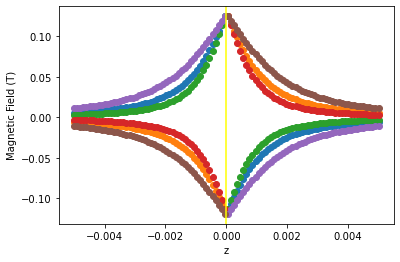

In [749]:
z=np.linspace(-0.005, 0.005, 100)
B_static_component_vector = np.vectorize(B_static_component)
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("z")
ax.set_ylabel("Magnetic Field (T)")
plt.axvline(x = 0, color='yellow')
plt.scatter(z, B_static_component_vector(-x,y,z))
plt.scatter(z, B_static_component_vector(-x,y,-z))
plt.scatter(z, B_static_component_vector(-x,-y,z))
plt.scatter(z, B_static_component_vector(-x,-y,-z))
plt.scatter(z, B_static_component_vector(x,y,z))
plt.scatter(z, B_static_component_vector(x,y,-z))

KeyboardInterrupt: 

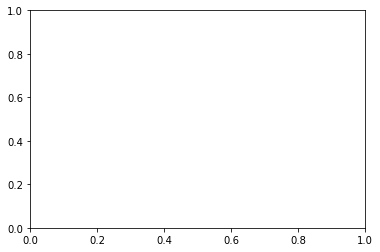

In [750]:
N=1000
feature_x=np.linspace(-b_x, b_x, N)
feature_y=np.linspace(-b_y, b_y, N)
[X, Y] = np.meshgrid(feature_x, feature_y)

B_static_vector = np.vectorize(B_static)

z_above = 2e-4
z_shift = 1e-4 # m

fig1, ax1 = plt.subplots(1, 1)
c1 = ax1.contourf(X, Y, B_static_vector(X, Y, z_above))
cbar1 = fig1.colorbar(c1)
cbar1.ax.set_ylabel('Magnetic Field (T)')

N_total = 20 
sum_B_static_vector = B_static_vector(X,Y,z_shift)
for N_stack in trange(N_total):
    #print(N_stack)
    sum_B_static_vector += B_static_vector(X,Y,z_above+(N_stack+1)*b_z)

fig2, ax2 = plt.subplots(1, 1)
c2 = ax2.contourf(X, Y, sum_B_static_vector)
cbar2 = fig2.colorbar(c2)
cbar2.ax.set_ylabel('Magnetic Field (T)')
